<a href="https://colab.research.google.com/github/03chrisk/PEFT-T5-on-CNN-dailynews/blob/main/Monkey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstractive Text Summarization with T5-small

## Table of Contents
1. [Introduction](#introduction)
    - 1.1 [Installing Dependencies](#installing-dependencies)
    - 1.2 [Loading the model and the dataset](#loading-the-model-and-the-dataset)
    - 1.3 [Exploratory Data Analysis](#exploratory-data-analysis)
2. [Data Preprocessing](#data-preprocessing)
    - 2.1 [Tokenizing the Data](#tokenizing-the-data)
    - 2.2 [Data Collator and Removing Columns](#data-collator-and-removing-columns)
    - 2.3 [Setting evaluation metrics for training](#setting-evaluation-metrics-for-training)
    - 2.4 [Helper Functions](#helper-functions)
3. [Base Model Testing](#base-model-testing)
4. [Full Fine-Tuning](#full-fine-tuning)
    - 4.1 [Setting up training config](#setting-up-training-config)
    - 4.2 [Training and logging system metrics](#training-and-logging-system-metrics)
    - 4.3 [Evaluation](#evaluation)
5. [Parameter Efficient Fine-Tuning (PEFT)](#parameter-efficient-fine-tuning-peft)
    - 5.1 [Setting up training and LoRa configs](#setting-up-training-and-lora-configs)
    - 5.2 [Training and logging system metrics](#training-and-logging-system-metrics-1)
    - 5.3 [Evaluation](#evaluation-1)
6. [Conclusion](#conclusion)

# Introduction

## Installing Dependencies

In [4]:
!pip install transformers datasets evaluate rouge_score torch matplotlib peft bert-score blue sentencepiece seaborn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import torch

# Check if a GPU is available to use
device = 0 if torch.cuda.is_available() else -1

device

0

In [2]:
import os

# Enables dynamic GPU memory allocation with expandable segments to reduce fragmentation and improve memory utilization
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
import torch
import random
import numpy as np

# Set seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using GPUs

set_seed(4242)

## Loading the Dataset

In [4]:
from datasets import load_dataset

ds = load_dataset("abisee/cnn_dailymail", "3.0.0")

ds.keys()

print(ds['train'])
print(ds['test'])
print(ds['validation'])

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 287113
})
Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 11490
})
Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 13368
})


## Exploratory Data Analysis

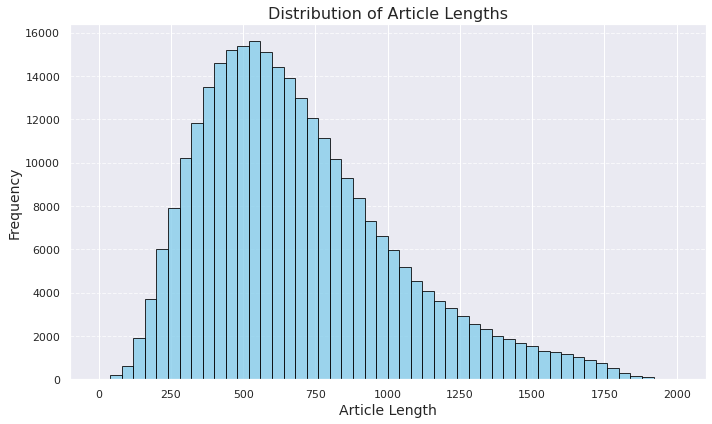

In [5]:
# Distribution of article lengths in the train set

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

article_lengths = [len(article.split()) for article in ds['train']['article']]  

plt.figure(figsize=(10, 6))

plt.hist(article_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.8, range=(0,2000))

plt.xlabel('Article Length', fontsize=14, fontweight='normal') 
plt.ylabel('Frequency', fontsize=14, fontweight='normal')
plt.title('Distribution of Article Lengths', fontsize=16, fontweight='normal')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

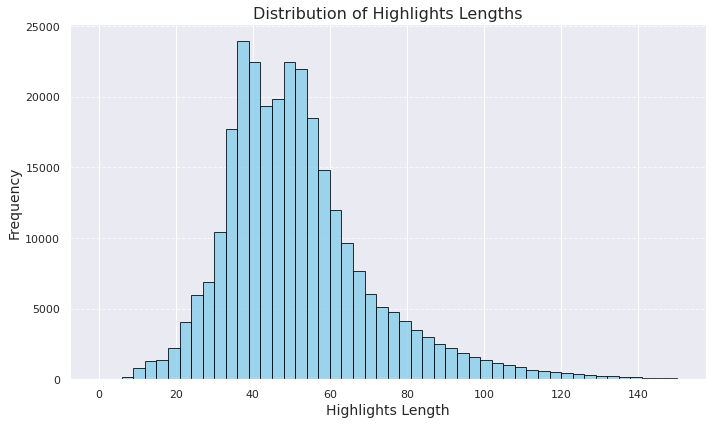

In [6]:
# Distribution of highlit lengths in the train set

article_lengths = [len(article.split()) for article in ds['train']['highlights']] 

plt.figure(figsize=(10, 6))

plt.hist(article_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.8, range=(0,150))


plt.xlabel('Highlights Length', fontsize=14, fontweight='normal') 
plt.ylabel('Frequency', fontsize=14, fontweight='normal')
plt.title('Distribution of Highlights Lengths', fontsize=16, fontweight='normal')


plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Data Preprocessing

In [7]:
# Select a subset of the data 

train_dataset = ds["train"].select(range(20000))

val_dataset = ds["validation"].select(range(750))

test_dataset = ds["test"]

In [8]:
# Set an test index to choose which index of the test set to display the summary for

TEST_INDEX = 5
model_name = "t5-base"
prefix = "Provide a detailed an concise summary of this article: " # used as the instructional prompting

## Tokenizing the Data

In [9]:
from transformers import AutoTokenizer 

# Load the T5 tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    inputs = [prefix + article for article in examples['article']]
    model_inputs = tokenizer(inputs, max_length=1500, truncation=True)

    labels = tokenizer(text_target=examples['highlights'], max_length=200, truncation=True)

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

In [12]:
# NOT NECESSARY TO RUN ----------------------------

#print labels of tokenized_train
print(tokenized_train[0].keys())

dict_keys(['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'])


In [13]:
# NOT NECESSARY TO RUN ----------------------------

# Inspecting the sizes of thi inputs and outputs to the tast
avg_input_size = sum(len(i['input_ids']) for i in tokenized_train)/len(tokenized_train['input_ids'])
first_input_size = len(tokenized_train[0]['input_ids'])

avg_output_size = sum(len(i['labels']) for i in tokenized_train)/len(tokenized_train['labels'])
first_output_size = len(tokenized_train[0]['labels'])

print(avg_output_size*avg_input_size)
print(avg_output_size, avg_input_size, first_input_size, first_output_size)

47035.48689
63.63 739.203 638 57


## Data Collator and Removing Columns

In [10]:
from transformers import DataCollatorForSeq2Seq

# Initialize the data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name, padding=True)

In [11]:
# Remove unnecessary columns from the tokenized sets
tokenized_train = tokenized_train.remove_columns(["highlights", "article", "id"])
tokenized_test = tokenized_test.remove_columns(["highlights", "article", "id"])
tokenized_val = tokenized_val.remove_columns(["highlights", "article", "id"])

# Check if removing columns was successful
print(tokenized_test.column_names)

['input_ids', 'attention_mask', 'labels']


In [12]:
# Convert dataset columns to PyTorch tensors for efficient model input with 'input_ids', 'attention_mask', and 'labels' fields

# For training dataset
tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# For val dataset
tokenized_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# For testing dataset
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


## Setting Evaluation Metrics for Training

In [13]:
# Import evaluation metric

import evaluate
rouge = evaluate.load("rouge")

In [14]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score

# Apply smoothing to BLEU score to handle cases with rare or unmatched n-grams.
smoothing_function = SmoothingFunction()

def compute_metrics_train(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # ROUGE scores
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Add BLEU score
    bleu_scores = []
    for pred, label in zip(decoded_preds, decoded_labels):
        reference_tokens = tokenizer.tokenize(label)
        generated_tokens = tokenizer.tokenize(pred)
        bleu_score = sentence_bleu([reference_tokens], generated_tokens, smoothing_function=smoothing_function.method1)
        bleu_scores.append(bleu_score)
    
    result["bleu"] = np.mean(bleu_scores)

    # Add BERTScore (F1)
    P, R, F1 = bert_score(decoded_preds, decoded_labels, lang="en", rescale_with_baseline=True)
    result["bert_f1"] = np.mean(F1.numpy())

    # Generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}


# Helper Functions

In [15]:
# Helper functions for tracking system metrics during training 

import time
import psutil
import subprocess
import os

def get_gpu_memory_usage():
    # Run nvidia-smi to get both used and total memory
    result = subprocess.run(
        ["nvidia-smi", "--query-gpu=memory.used,memory.total", "--format=csv,nounits,noheader"],
        stdout=subprocess.PIPE
    )
    used_memory, total_memory = result.stdout.decode("utf-8").strip().split("\n")[0].split(", ")

    return int(used_memory), int(total_memory)

def track_performance(model_type):
    process = psutil.Process(os.getpid())

    start_time = time.time()
    
    trainer.train()

    # Track memory and time
    memory_usage = process.memory_info().rss / (1024 * 1024)
    gpu_memory_used, gpu_memory_total = get_gpu_memory_usage()
    end_time = time.time()

    time_elapsed = end_time - start_time

    print(f"{model_type} - Time taken: {time_elapsed:.2f} seconds")
    print(f"{model_type} - CPU Memory usage: {memory_usage:.2f} MB")
    print(f"{model_type} - GPU Memory usage: {gpu_memory_used} MB / {gpu_memory_total} MB")


In [49]:
# Helper Functions for loading, generating summaries and testing 

def load_base_model(model_name):
    config = T5Config.from_pretrained(model_name)

    config.task_specific_params['summarization']['max_length'] = 200

    base_model = T5ForConditionalGeneration.from_pretrained(model_name, config=config)
    
    base_model.to(device)
    
    return base_model

def generate_summary(example, model, peft, custom_tokenizer=tokenizer):
    input_text = prefix + example["article"]
    input_ids = custom_tokenizer.encode(input_text, return_tensors="pt", max_length=1500, truncation=True).to(device)
    if peft:
        model.eval()  # Ensure that the model uses the correct generation method with PEFT (LoRA)
        with torch.no_grad():
            output = model.generate(input_ids=input_ids, max_new_tokens=200)
    else:       
        output = model.generate(input_ids, max_new_tokens = 200)
    summary = custom_tokenizer.decode(output[0], skip_special_tokens=True)
    return summary

def compute_metrics_test(example, model, peft=False):
    input_ids = example['input_ids'].to(device)  # Move input_ids to the same device as the model
    labels = example['labels'].to(device)  # Move labels to the same device as well

    input_ids = input_ids.unsqueeze(0)  # Add batch dimension

    # Generate the summary using model.generate()
    if peft:
        model.eval()
        with torch.no_grad():
            generated_ids = model.generate(input_ids=input_ids, max_new_tokens=200)
    else: 
        generated_ids = model.generate(
            input_ids,
            max_length=200,
            num_beams=1,
        )

    decoded_pred = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        
    labels = labels.cpu().numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_label = tokenizer.decode(labels, skip_special_tokens=True)

    # Compute ROUGE scores
    rouge_result = rouge.compute(predictions=[decoded_pred], references=[decoded_label], use_stemmer=True)

    # Compute BERTScore (only F1)
    _, _, F1 = bert_score([decoded_pred], [decoded_label], lang='en', rescale_with_baseline=True)

    # Compute BLEU score
    # Tokenize the generated and reference summaries
    reference_tokens = tokenizer.tokenize(decoded_label)
    generated_tokens = tokenizer.tokenize(decoded_pred)
        
    bleu_score = sentence_bleu([reference_tokens], generated_tokens, smoothing_function=smoothing_function.method1)

    return {
        'rouge': rouge_result,
        'bert_f1': F1.item(),  # Return only F1 score
        'bleu': bleu_score  # Return BLEU score
    }
    
def evaluate_model(model, peft=False):
    # Initialize accumulators for each ROUGE metric, BERT F1 score, and BLEU score
    rouge1_total, rouge2_total, rougel_total = 0, 0, 0
    bert_f1_total = 0
    bleu_total = 0
    num_examples = 100  # Adjust as needed

    # Loop through the test examples and accumulate the scores
    for i in range(num_examples):
        example = tokenized_test[i]  # Get one example from the dataset
        scores = compute_metrics_test(example, model, peft)  # Get the ROUGE and BERT scores
        
        # Accumulate the ROUGE scores
        rouge1_total += scores['rouge']['rouge1']
        rouge2_total += scores['rouge']['rouge2']
        rougel_total += scores['rouge']['rougeL']

        # Accumulate BERT F1 scores
        bert_f1_total += scores['bert_f1']

        # Accumulate BLEU scores
        bleu_total += scores['bleu']

    # Compute the averages
    rouge1_avg = rouge1_total / num_examples
    rouge2_avg = rouge2_total / num_examples
    rougel_avg = rougel_total / num_examples
    bert_f1_avg = bert_f1_total / num_examples
    bleu_avg = bleu_total / num_examples
    
    return rouge1_avg, rouge2_avg, rougel_avg, bert_f1_avg, bleu_avg

# Base Model Testing

In [17]:
from transformers import T5Config, T5ForConditionalGeneration
import torch

base_model = load_base_model(model_name)

example = test_dataset[TEST_INDEX]  # Get one example from the dataset
summary = generate_summary(example, base_model, peft=False)  # Generate summary

# Print the input article, reference summary, and generated summary
print("Original Article:\n", example['article'])
print("\nReference Summary (Highlights):\n", example['highlights'])
print("\nGenerated Summary:\n", summary)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Original Article:
 (CNN)He's a blue chip college basketball recruit. She's a high school freshman with Down syndrome. At first glance Trey Moses and Ellie Meredith couldn't be more different. But all that changed Thursday when Trey asked Ellie to be his prom date. Trey -- a star on Eastern High School's basketball team in Louisville, Kentucky, who's headed to play college ball next year at Ball State -- was originally going to take his girlfriend to Eastern's prom. So why is he taking Ellie instead? "She's great... she listens and she's easy to talk to" he said. Trey made the prom-posal (yes, that's what they are calling invites to prom these days) in the gym during Ellie's P.E. class. Trina Helson, a teacher at Eastern, alerted the school's newspaper staff to the prom-posal and posted photos of Trey and Ellie on Twitter that have gone viral. She wasn't surpristed by Trey's actions. "That's the kind of person Trey is," she said. To help make sure she said yes, Trey entered the gym arme

In [19]:
import numpy as np
from bert_score import score as bert_score  # Import BERTScore
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothing_function = SmoothingFunction()

# Move the model to the appropriate device
base_model.to(device)

rouge1_avg, rouge2_avg, rougel_avg, bert_f1_avg, bleu_avg = evaluate_model(base_model)

# Print the averaged scores
print(f"Averaged ROUGE-1: {rouge1_avg:.4f}")
print(f"Averaged ROUGE-2: {rouge2_avg:.4f}")
print(f"Averaged ROUGE-L: {rougel_avg:.4f}")
print(f"Averaged BERT F1: {bert_f1_avg:.4f}")
print(f"Averaged BLEU: {bleu_avg:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Averaged ROUGE-1: 0.4400
Averaged ROUGE-2: 0.1727
Averaged ROUGE-L: 0.2904
Averaged BERT F1: 0.3113
Averaged BLEU: 0.1501


# Full Fine-Tuning

## Setting up training config

In [20]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback, T5Config, T5ForConditionalGeneration, get_linear_schedule_with_warmup

# Loading the base model that will be fine tuned
full_tuned_model = load_base_model(model_name)

## Training and logging system metrics

In [22]:
# Specify the training args for full finetuning on the T5-base model 

from torch.optim import AdamW

WEIGHT_DECAY= 0.001
LEARNING_R = 5e-5

num_training_steps = len(tokenized_train) // (2 * 8) * 2  # Assuming 2 epochs and batch_size=2, ga = 8
WARMUP_STEPS = int(num_training_steps * 0.1) 

optimizer = AdamW(
    full_tuned_model.parameters(),
    lr=LEARNING_R,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999),  
    eps=1e-8             
)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=num_training_steps
)


EVAL_STEPS = int(len(tokenized_train) // (2 * 8 * 5)) # batch_size * ga-steps * how many times per epoch to evaluate (5 here)
LOG_STEPS = EVAL_STEPS // 5

training_args = Seq2SeqTrainingArguments(
    output_dir="t5base",
    eval_strategy="steps",
    eval_steps = EVAL_STEPS, 
    save_steps = EVAL_STEPS, 
    logging_steps = LOG_STEPS,
    learning_rate=LEARNING_R,
    per_device_train_batch_size=6,  # Increasing might cause CUDA out of memory
    per_device_eval_batch_size=6,  # Increasing might cause CUDA out of memory
    weight_decay=WEIGHT_DECAY,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=True, 
    push_to_hub=False,
    remove_unused_columns=False,
    gradient_accumulation_steps=8,
    load_best_model_at_end=True,  # Load the best model after training
    warmup_steps=WARMUP_STEPS,  # Include warmup steps
)

trainer = Seq2SeqTrainer(
    model=full_tuned_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_train,
    optimizers=(optimizer, scheduler),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [23]:
# Fine tuning and tracking system metrics
track_performance("Full Fine-Tuned: ")


/home3/s5232686/.local/lib/python3.10/site-packages/transformers/data/data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

## Evaluation

In [21]:
# Saving the model
model.save_pretrained("./first-full-t5base-idk")
tokenizer.save_pretrained("./first-trained-t5base-token")

('./first-trained-t5base-token/tokenizer_config.json',
 './first-trained-t5base-token/special_tokens_map.json',
 './first-trained-t5base-token/spiece.model',
 './first-trained-t5base-token/added_tokens.json',
 './first-trained-t5base-token/tokenizer.json')

In [24]:
# Evalutating the fully fine tuned model

import torch

full_tuned_model.to(device)

# Example usage:
example = test_dataset[TEST_INDEX]  # Get one example from the dataset
summary = generate_summary(example, full_tuned_model, peft=False)  # Generate summary

# Print the input article, reference summary, and generated summary
print("Original Article:\n", example['article'])
print("\nReference Summary (Highlights):\n", example['highlights'])
print("\nGenerated Summary:\n", summary)

Original Article:
 (CNN)He's a blue chip college basketball recruit. She's a high school freshman with Down syndrome. At first glance Trey Moses and Ellie Meredith couldn't be more different. But all that changed Thursday when Trey asked Ellie to be his prom date. Trey -- a star on Eastern High School's basketball team in Louisville, Kentucky, who's headed to play college ball next year at Ball State -- was originally going to take his girlfriend to Eastern's prom. So why is he taking Ellie instead? "She's great... she listens and she's easy to talk to" he said. Trey made the prom-posal (yes, that's what they are calling invites to prom these days) in the gym during Ellie's P.E. class. Trina Helson, a teacher at Eastern, alerted the school's newspaper staff to the prom-posal and posted photos of Trey and Ellie on Twitter that have gone viral. She wasn't surpristed by Trey's actions. "That's the kind of person Trey is," she said. To help make sure she said yes, Trey entered the gym arme

In [25]:
# Evalutating the fully fine tuned model

import numpy as np
from bert_score import score as bert_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothing_function = SmoothingFunction()

# Move the model to the appropriate device
full_tuned_model.to(device)

rouge1_avg, rouge2_avg, rougel_avg, bert_f1_avg, bleu_avg = evaluate_model(full_tuned_model)

# Print the averaged scores
print(f"Averaged ROUGE-1: {rouge1_avg:.4f}")
print(f"Averaged ROUGE-2: {rouge2_avg:.4f}")
print(f"Averaged ROUGE-L: {rougel_avg:.4f}")
print(f"Averaged BERT F1: {bert_f1_avg:.4f}")
print(f"Averaged BLEU: {bleu_avg:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Averaged ROUGE-1: 0.3295
Averaged ROUGE-2: 0.1134
Averaged ROUGE-L: 0.2701
Averaged BERT F1: 0.2511
Averaged BLEU: 0.0970


# Parameter Efficient Fine-Tuning (PEFT)

## Setting up training and LoRa configs

In [21]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback, T5Config, T5ForConditionalGeneration

# Load the base model for LoRa fine tuning
lora_model = load_base_model(model_name)

In [36]:
# Configure LoRa settings

from peft import LoraConfig, get_peft_model


lora_config = LoraConfig(
    r=16, 
    lora_alpha=32,  
    lora_dropout=0.1, 
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

# Wrap the model with LoRA configuration
lora_model = get_peft_model(lora_model, lora_config)
lora_model.print_trainable_parameters()

trainable params: 1,769,472 || all params: 224,673,024 || trainable%: 0.7876


In [37]:
# Training args for fine tuning the T5-base using LoRa

from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
WEIGHT_DECAY= 0.1  # try 0.1
LEARNING_R = 1e-5

num_training_steps = len(tokenized_train) // (2 * 6) * 2  # Assuming 2 epochs and batch_size=2, ga = 8
WARMUP_STEPS = int(num_training_steps * 0.1) # was 0.1

optimizer = AdamW(
    lora_model.parameters(),
    lr=LEARNING_R,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999),  
    eps=1e-8             
)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=num_training_steps
)

EVAL_STEPS = int(len(tokenized_train) // (6 * 2 * 5)) # batch_size * ga-steps * how many times per epoch to evaluate (5 here)
LOG_STEPS = EVAL_STEPS // 5

training_args = Seq2SeqTrainingArguments(
    output_dir="t5base",
    eval_strategy="steps",
    eval_steps = EVAL_STEPS, 
    save_steps = EVAL_STEPS, 
    logging_steps = LOG_STEPS,
    learning_rate=LEARNING_R,
    per_device_train_batch_size=6,  # DO NOT CHANGE (BESTLY)
    per_device_eval_batch_size=6,  # DO NOT CHANGE (BESTLY)
    weight_decay=WEIGHT_DECAY,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True, 
    push_to_hub=False,
    remove_unused_columns=False,
    gradient_accumulation_steps=2,
    load_best_model_at_end=True,  # Load the best model after training
    warmup_steps=WARMUP_STEPS,  # Include warmup steps
)

trainer = Seq2SeqTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_train,
    optimizers=(optimizer, scheduler),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

## Training and logging system metrics

In [38]:
# LoRa finetuning and tracking system metrics
track_performance("LoRA")


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Bert F1,Gen Len
333,1.886400,1.971725,0.250200,0.095000,0.200100,0.200100,0.037800,0.165300,19.000000
666,1.633200,1.745763,0.253100,0.103200,0.206200,0.206400,0.045000,0.185400,19.000000
999,1.541500,1.682871,0.258600,0.105500,0.211000,0.211000,0.047500,0.190500,19.000000
1332,1.531300,1.676130,0.257300,0.106000,0.210800,0.210800,0.047900,0.193400,19.000000
1665,1.549300,1.675682,0.257300,0.105800,0.211100,0.211000,0.047800,0.194100,19.000000


/home3/s5232686/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home3/s5232686/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: 

LoRA - Time taken: 1494.58 seconds
LoRA - CPU Memory usage: 4025.35 MB
LoRA - GPU Memory usage: 21925 MB / 40960 MB


## Evaluation

In [57]:
# Saving
lora_model.save_pretrained("./try")
tokenizer.save_pretrained("./try-token")

('./try-token/tokenizer_config.json',
 './try-token/special_tokens_map.json',
 './try-token/spiece.model',
 './try-token/added_tokens.json',
 './try-token/tokenizer.json')

In [58]:
loraa_model = T5ForConditionalGeneration.from_pretrained("./try")
tokenizer_test = AutoTokenizer.from_pretrained("./try-token")

OSError: None is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [62]:
# Evaluating the LoRa fine tuned model
import torch

lora_model.to(device)

# Example usage:
example = test_dataset[TEST_INDEX]  # Get one example from the dataset
summary = generate_summary(example, lora_model, peft=True)  # Generate summary

# Print the input article, reference summary, and generated summary
print("Original Article:\n", example['article'])
print("\nReference Summary (Highlights):\n", example['highlights'])
print("\nGenerated Summary:\n", summary)


Original Article:
 (CNN)He's a blue chip college basketball recruit. She's a high school freshman with Down syndrome. At first glance Trey Moses and Ellie Meredith couldn't be more different. But all that changed Thursday when Trey asked Ellie to be his prom date. Trey -- a star on Eastern High School's basketball team in Louisville, Kentucky, who's headed to play college ball next year at Ball State -- was originally going to take his girlfriend to Eastern's prom. So why is he taking Ellie instead? "She's great... she listens and she's easy to talk to" he said. Trey made the prom-posal (yes, that's what they are calling invites to prom these days) in the gym during Ellie's P.E. class. Trina Helson, a teacher at Eastern, alerted the school's newspaper staff to the prom-posal and posted photos of Trey and Ellie on Twitter that have gone viral. She wasn't surpristed by Trey's actions. "That's the kind of person Trey is," she said. To help make sure she said yes, Trey entered the gym arme

In [50]:
# Evaluating the LoRa fine tuned model
import numpy as np
from bert_score import score as bert_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothing_function = SmoothingFunction()

# Move the model to the appropriate device
lora_model.to(device)

rouge1_avg, rouge2_avg, rougel_avg, bert_f1_avg, bleu_avg = evaluate_model(lora_model, peft=True)

# Print the averaged scores
print(f"Averaged ROUGE-1: {rouge1_avg:.4f}")
print(f"Averaged ROUGE-2: {rouge2_avg:.4f}")
print(f"Averaged ROUGE-L: {rougel_avg:.4f}")
print(f"Averaged BERT F1: {bert_f1_avg:.4f}")
print(f"Averaged BLEU: {bleu_avg:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Averaged ROUGE-1: 0.3530
Averaged ROUGE-2: 0.1488
Averaged ROUGE-L: 0.2654
Averaged BERT F1: 0.2963
Averaged BLEU: 0.1444


# Conclusion

